<a href="https://colab.research.google.com/github/mudrab/Tensorflow/blob/main/SMS_Spam_Detection_using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.geeksforgeeks.org/sms-spam-detection-using-tensorflow-in-python/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Reading the data
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


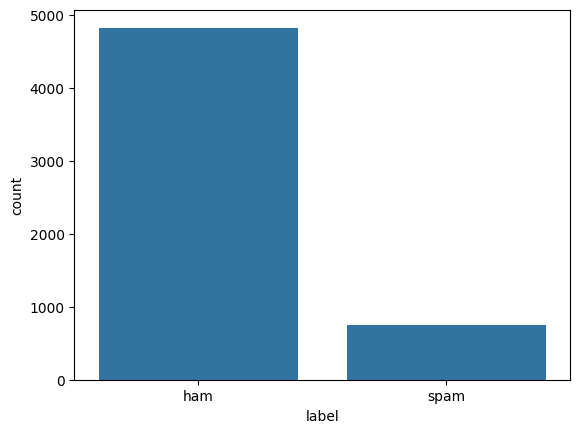

In [ ]:
sns.countplot(x=df['label'])
plt.show()


In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


16


In [ ]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)


15686


In [ ]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


In [ ]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}

    return model_results_dict

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  '''
  fit the model with given epochs, train
  and test data
  '''
  # Check if validation data is provided
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test)) #Removed validation steps argument
  else:
      # Handle case where validation data is not provided
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history



In [ ]:
# ... (previous code)

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  '''
  fit the model with given epochs, train
  and test data
  '''
  # Convert X_train and X_test to NumPy arrays with dtype=object
  X_train = np.asarray(X_train, dtype=object)
  X_test = np.asarray(X_test, dtype=object)

  # Check if validation data is provided
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test)) #Removed validation steps argument
  else:
      # Handle case where validation data is not provided
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history
# ... (rest of the code)

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test) # fit the model




Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.8977 - loss: 0.2930 - val_accuracy: 0.9776 - val_loss: 0.0710
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9885 - loss: 0.0481 - val_accuracy: 0.9803 - val_loss: 0.0648
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9977 - loss: 0.0147 - val_accuracy: 0.9812 - val_loss: 0.0653
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9839 - val_loss: 0.0815
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 1.0000 - loss: 4.4342e-04 - val_accuracy: 0.9830 - val_loss: 0.1022


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Disable XLA compilation
tf.config.optimizer.set_jit(False)

# model with functional api
input_layer = keras.Input(shape=[], dtype=tf.string)

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                        trainable=False,
                        input_shape=[],
                        dtype=tf.string,
                        name='USE')

# Create a Lambda layer to wrap the use_layer call
# Specify the output shape of the USE layer
x = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation=keras.activations.relu)(x)
output_layer = layers.Dense(1, activation=keras.activations.sigmoid)(x)

model_3 = keras.Model(input_layer, output_layer)

compile_model(model_3)


history_3 = fit_model(model_3, epochs=5)

# This code is modified by Susobhan Akhuli


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8742 - loss: 0.4186 - val_accuracy: 0.9713 - val_loss: 0.1049
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9744 - loss: 0.0917 - val_accuracy: 0.9767 - val_loss: 0.0671
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9836 - loss: 0.0594 - val_accuracy: 0.9812 - val_loss: 0.0580
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9869 - loss: 0.0465 - val_accuracy: 0.9830 - val_loss: 0.0538
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9860 - loss: 0.0532 - val_accuracy: 0.9830 - val_loss: 0.0520


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd # Import pandas to check for Series type

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    # Convert X to a NumPy array with dtype=object if it's a Pandas Series
    # This ensures the input format is consistent for prediction
    if isinstance(X, pd.Series):
        X = X.to_numpy(dtype=object)
    elif not isinstance(X, np.ndarray):
        # Handle other potential incompatible types by converting to numpy array
        X = np.asarray(X, dtype=object)

    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}

    return model_results_dict

# The rest of the code remains the same as before
# ...
def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  '''
  fit the model with given epochs, train
  and test data
  '''
  # Convert X_train and X_test to NumPy arrays with dtype=object
  X_train = np.asarray(X_train, dtype=object)
  X_test = np.asarray(X_test, dtype=object)

  # Check if validation data is provided
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test)) #Removed validation steps argument
  else:
      # Handle case where validation data is not provided
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history

In [ ]:
def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    # Convert X to a NumPy array with dtype=object if it's a Pandas Series
    if isinstance(X, pd.Series):
        X = X.to_numpy(dtype=object)

    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}

    return model_results_dict